<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Otimização do Modelo SARIMA</font></b></strong>

Na Aula 17 estudamos e criamos um Modelo SARIMA aplicando Grid Search Stepwise para buscar os melhores valores dos hiperparâmetros.

Agora, vamos tentar melhorar a performance do modelo criado na Aula 17 mudando a estratégia do Grid Search.

Vamos ao trabalho.

Obs: Esta aula considera que você já finalizou a Aula 17. Aqui está o link da Aula 17:

https://colab.research.google.com/drive/11rvyw8TlZ79SmsfyPsvnWwCr3k1a5SK_

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
matplotlib.style.use('ggplot')
%matplotlib inline

## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [2]:
# Carrega os dados
dados = pd.read_csv('data/vendasHistoricas.csv')

In [3]:
# Shape
dados.shape

(9994, 21)

In [4]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [5]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [6]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [7]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [8]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [9]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [10]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [11]:
# Vamos checar os valores únicos por coluna (para ajudar a definir se a variável é categórica ou não)
for c in dados.columns:
    if len(set(dados[c])) < 20:
        print(c,set(dados[c]))

ship_mode {'Standard Class', 'First Class', 'Second Class', 'Same Day'}
segment {'Corporate', 'Consumer', 'Home Office'}
country {'United States'}
region {'East', 'South', 'West', 'Central'}
category {'Office Supplies', 'Furniture', 'Technology'}
sub_category {'Paper', 'Envelopes', 'Art', 'Binders', 'Fasteners', 'Supplies', 'Accessories', 'Appliances', 'Labels', 'Chairs', 'Machines', 'Storage', 'Copiers', 'Furnishings', 'Tables', 'Bookcases', 'Phones'}
quantity {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
discount {0.0, 0.8, 0.2, 0.3, 0.45, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15}


In [12]:
# Vamos checar as categorias de itens
#a = dados['category'].value_counts()
#fig = px.bar(a, x = a.index, y = a.values, height = 400)
#fig.update_layout(title = {'text': "Categorias de Itens", 
#                           'y':0.9,'x':0.5,'xanchor': 
#                           'center','yanchor': 'top'},
#                  xaxis_title = "Categoria",
#                  yaxis_title = "Total de Itens")
#fig.show(renderer = 'svg')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [13]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [14]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

In [15]:
# Como está ficando cada dataset?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [16]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [17]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

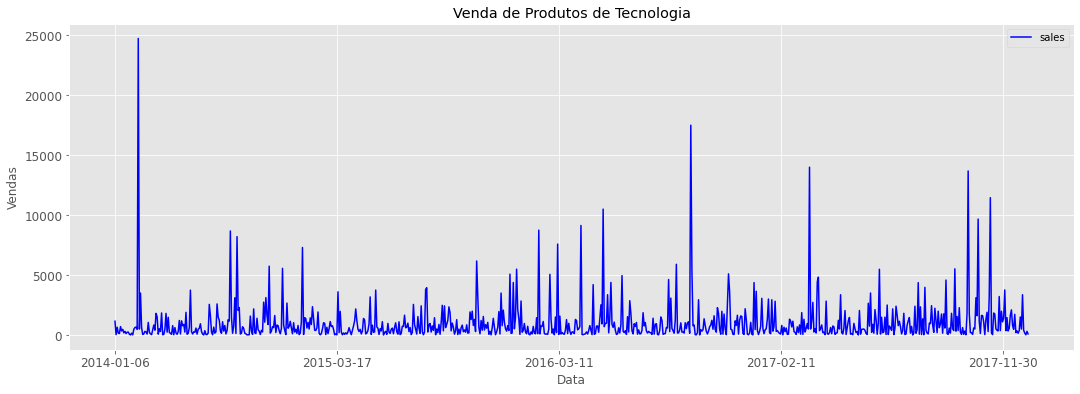

In [18]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [19]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [20]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [21]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [22]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [23]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [24]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

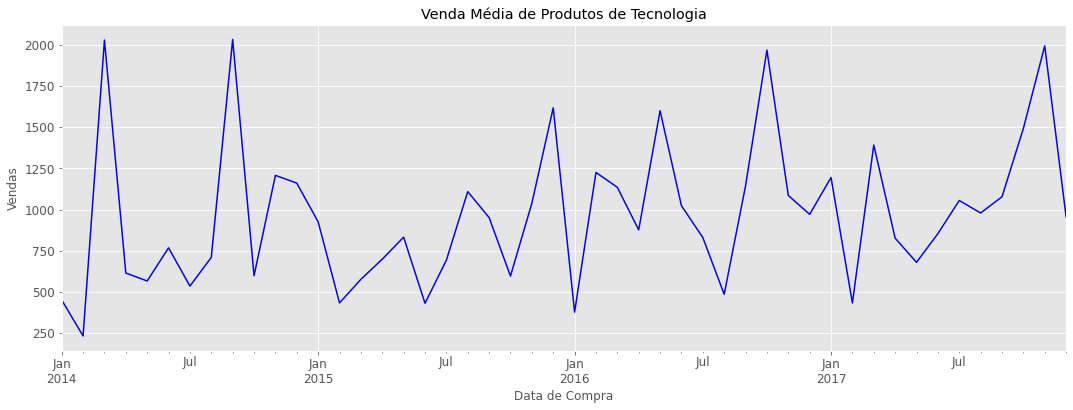

In [25]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

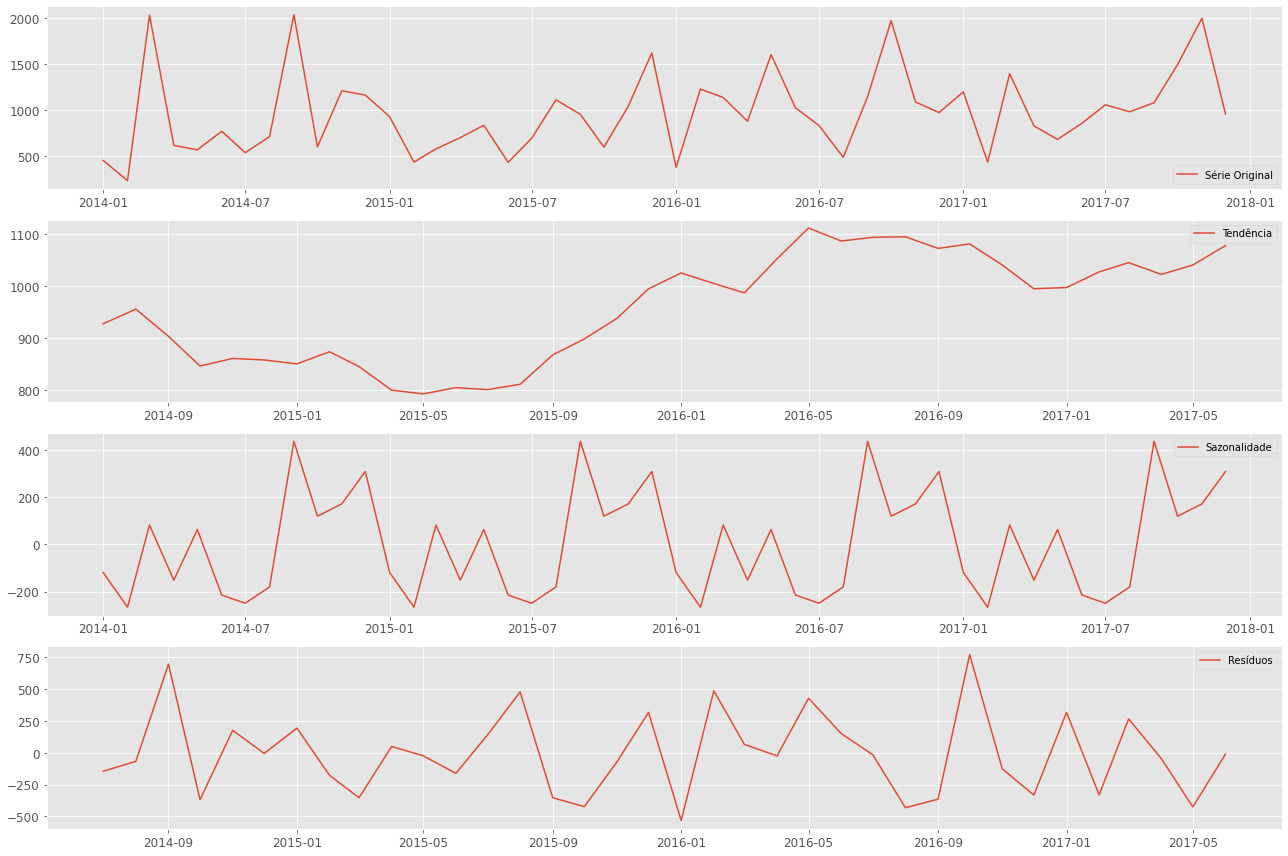

In [26]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [27]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

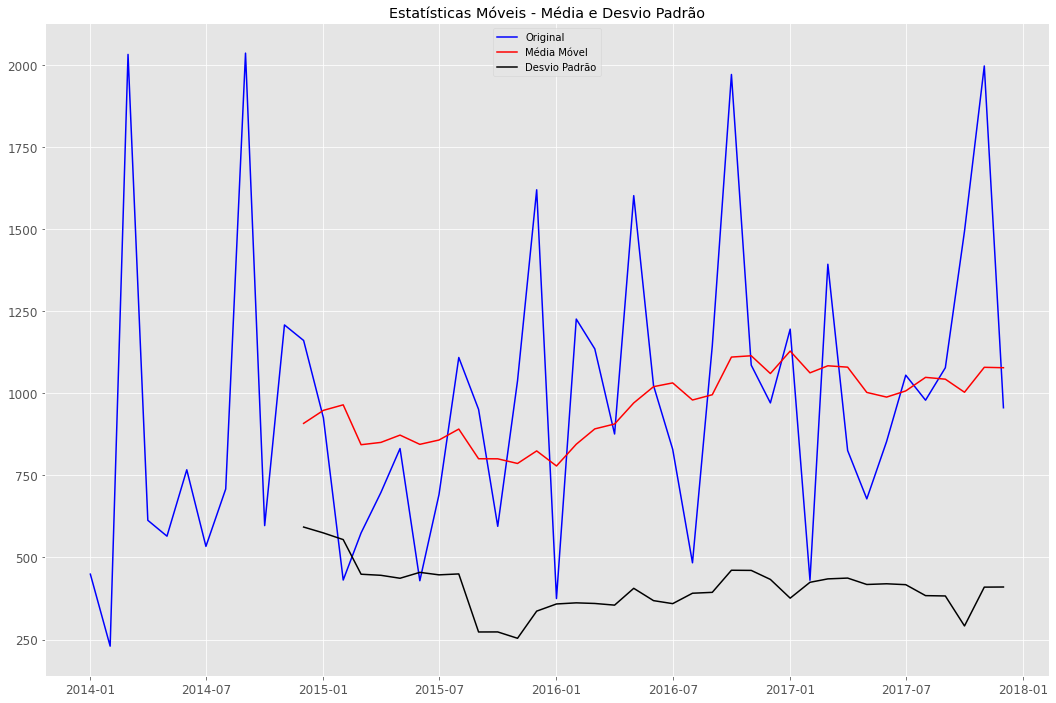


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [28]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

In [29]:
# Divisão em treino e teste
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

In [30]:
len(trainset)

36

In [31]:
len(testset)

12

### Função Para o Cálculo da Acurácia

In [32]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

## Otimização do Modelo SARIMA

### Grid Search Método 2 

Neste método de Grid Search, nós testamos diversas combinações dos hiperparâmetros do modelo SARIMA. Tome cuidado para não exagerar nas combinações. Valores de 0 e 1 resolvem a grande maioria dos problemas.

In [33]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 2)

Agora geramos diferentes combinações de p, d e q.

In [34]:
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [35]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [36]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [37]:
# Grid Search
#warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(trainset,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:588.2102390405763
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:376.5749597363521
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:363.32063002979925
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:176.73487847021386
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:379.0151254818642
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:364.00767949757034
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:191.64720213115754
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:178.37434230325258
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:556.747755138066
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:350.05143076948787
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:350.4099375968419
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:159.51605623612735
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:379.85514414686827
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:349.45783977782867
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:193.63316082077668
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:160.23413861410225
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:543.2769139724523
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:

In [38]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(trainset,
                                             order = (0, 1, 1),
                                             seasonal_order = (0, 1, 1, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [39]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [40]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -70.363
Date:                            Tue, 14 Jun 2022   AIC                            146.726
Time:                                    11:26:35   BIC                            147.318
Sample:                                01-01-2014   HQIC                           145.449
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0017     20.387     -0.049      0.961     -40.960      38.956
ma.S.L12      -1.1348     11.642   

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a otimizaçã dos hiperparâmetros.

In [42]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

**Diagnóstico do Modelo:**

- Nossa principal preocupação é garantir que os resíduos do nosso modelo não sejam correlacionados e sejam normalmente distribuídos com média zero.

- Se o modelo SARIMA não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

O diagnóstico do modelo sugere que o resíduo do modelo é normalmente distribuído com base no seguinte:

- No gráfico superior direito, a linha azul do KDE segue de perto a linha N (0,1). Onde N (0,1) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. Essa é uma boa indicação de que os resíduos são normalmente distribuídos.

- O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras coletadas de uma distribuição normal padrão. Novamente, essa é uma forte indicação de que os resíduos são normalmente distribuídos.

- Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

- Isso é confirmado pelo gráfico de autocorrelação (isto é, correlograma) no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si.

In [43]:
# Vamos fazer previsões um passo a frente
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2017-01-01'), 
                                                       end = pd.to_datetime('2017-12-01'),
                                                       dynamic = False)

In [44]:
# Intervalo de confiança
sarima_predict_conf_2 = sarima_predict_2.conf_int()
sarima_predict_conf_2

,lower sales,upper sales
2017-01-01,-408.643641,2022.653427
2017-02-01,-390.161742,2010.056561
2017-03-01,154.137546,2549.478905
2017-04-01,-284.650156,2110.560881
2017-05-01,-55.342622,2339.867904
2017-06-01,-294.649548,2100.563877
2017-07-01,-351.227926,2043.988488
2017-08-01,-260.529759,2134.689648
2017-09-01,290.811345,2686.033810
2017-10-01,36.486066,2431.714021


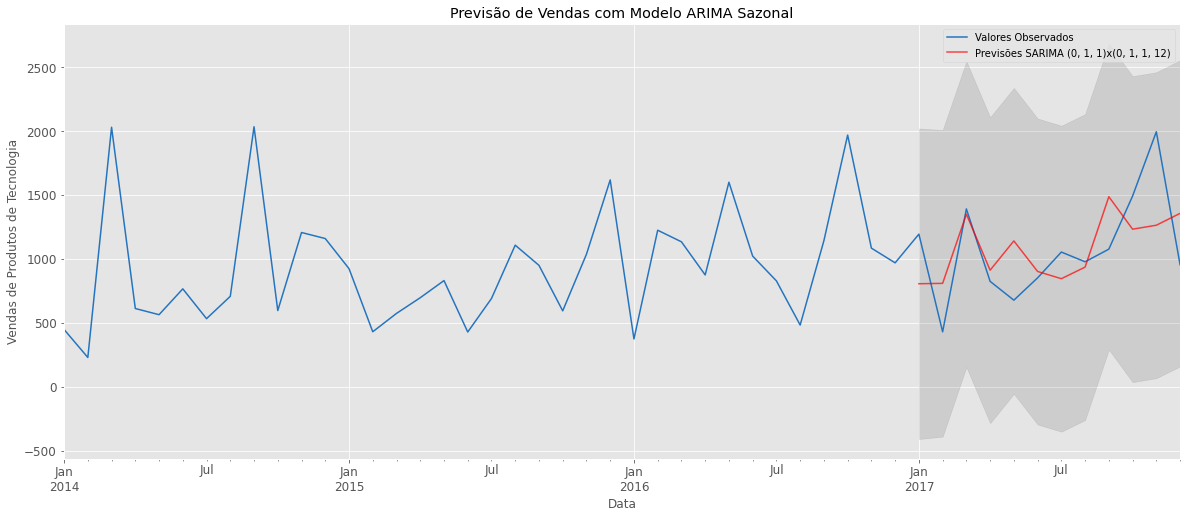

In [45]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 1)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_2.index,
                # lower sales
                sarima_predict_conf_2.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Vendas com Modelo ARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [46]:
# Calculando a performance
sarima_results = performance(testset, sarima_predict_2.predicted_mean)
sarima_results

MSE das previsões é 125009.39
RMSE das previsões é 353.57
MAPE das previsões é 30.55


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [47]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 60)

In [48]:
# Intervalo de confiança
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
horizonte_60_predict_2_conf_2

,lower sales,upper sales
2017-01-01,-408.643641,2022.653427
2017-02-01,-390.161742,2010.056561
2017-03-01,154.137546,2549.478905
2017-04-01,-284.650156,2110.560881
2017-05-01,-55.342622,2339.867904
2017-06-01,-294.649548,2100.563877
2017-07-01,-351.227926,2043.988488
2017-08-01,-260.529759,2134.689648
2017-09-01,290.811345,2686.033810
2017-10-01,36.486066,2431.714021


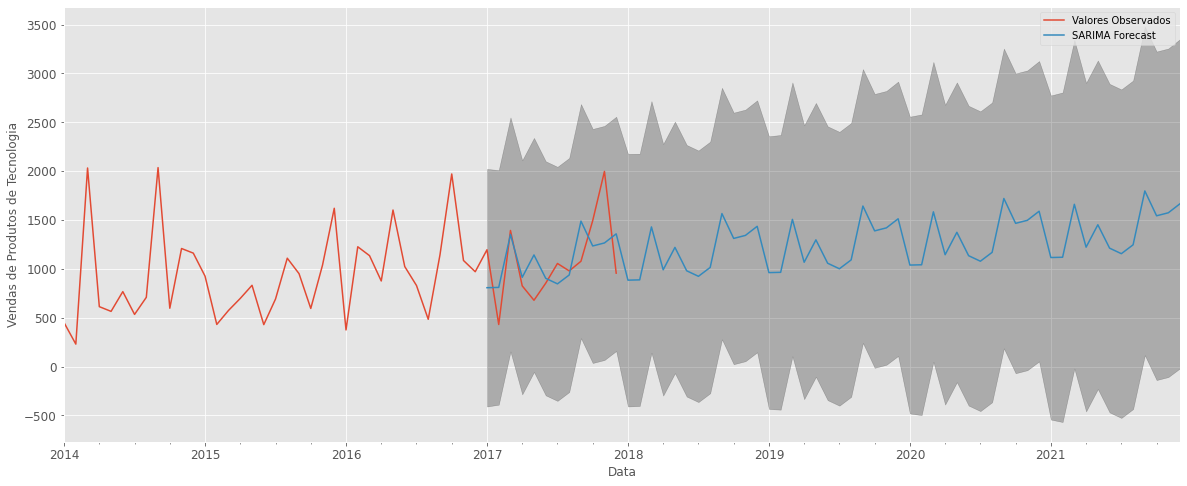

In [49]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = media_vendas_tecnologia.plot(label = 'Valores Observados')

# Plot dos valores previstos
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMA Forecast')

# Plot do intervalo de confiança
ax.fill_between(horizonte_60_predict_2_conf_2.index,
                horizonte_60_predict_2_conf_2.iloc[:, 0],
                horizonte_60_predict_2_conf_2.iloc[:, 1], color = 'k', alpha = .25)

# Plot
ax.set_xlabel('Data')
ax.set_ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [50]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.16343181]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

E, portanto, um modelo SARIMA (1, 1, 0)x(1, 1, 0, 12) fornece um bom ajuste e boa capacidade de previsão.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA (1,1) - AIC = 550.3 e RMSE = 420.2
- Aula 16 --> Modelo ARIMA (6,0,2) - AIC = 559.4 e RMSE = 401.5
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12)  - AIC = 176.74 e RMSE = 425.89
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12)  - AIC = 146.77 e RMSE = 353.57

Que diferença faz uma otimização de hiperparâmetros, não é verdade? Incrível como conseguimos melhorar a performance do nosso modelo aplicando técnicas de otimização.

Embora não seja o caso aqui, se tivermos discrepâncias entre o AIC e o RMSE, nossa escolha deve ser pelo AIC.

O RMSE é o erro do modelo com os dados atuais, de teste.

O AIC avalia a performance global do modelo e a sua capacidade de prever em um horizonte de previsão além das amostra de teste (ou seja, com novos dados). E isso é o que queremos! Logo, havendo discrepância das métricas, devemos escolher o modelo com menor AIC.

Seríamos capazes de melhorar a performance do modelo SARIMA mais uma vez? Está ficando difícil, mas vamos tentar na Aula 19.